%%latex
# Анализ объектов

Возьмите датасет вашего варианта из лабораторной работы № 1. Если вы раньше применяли бинаризацию целевого признака, то сейчас этого делать не нужно.

In [349]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_path = 'bodyfat.csv'
data = pd.read_csv(file_path)

data.dropna(inplace=True)

X = data.drop(columns=['Neck'])
y = data['Neck']
print(X.head())
print(y.head())

   Density  BodyFat  Age  Weight  Height  Chest  Abdomen    Hip  Thigh  Knee  \
0   1.0708     12.3   23  154.25   67.75   93.1     85.2   94.5   59.0  37.3   
1   1.0853      6.1   22  173.25   72.25   93.6     83.0   98.7   58.7  37.3   
2   1.0414     25.3   22  154.00   66.25   95.8     87.9   99.2   59.6  38.9   
3   1.0751     10.4   26  184.75   72.25  101.8     86.4  101.2   60.1  37.3   
4   1.0340     28.7   24  184.25   71.25   97.3    100.0  101.9   63.2  42.2   

   Ankle  Biceps  Forearm  Wrist  
0   21.9    32.0     27.4   17.1  
1   23.4    30.5     28.9   18.2  
2   24.0    28.8     25.2   16.6  
3   22.8    32.4     29.4   18.2  
4   24.0    32.2     27.7   17.7  
0    36.2
1    38.5
2    34.0
3    37.4
4    34.4
Name: Neck, dtype: float64


## Выступ (отступ)

Выступ - это такая функция M(x), что для объектов, лежащих глубоко внутри своего класса, т.е. для эталонов она принимает большие положительные значения. Для периферийных объектов, лежащих на границе классов, M(x)≈0. Для объектов одного класса, расположенных среди объектов другого класса, выступ M(x) должен принимать отрицательные значения. Так как границы классов зачастую нельзя четко определить, то объекты последнего типа с M(x)<0 делят на две подгруппы: ошибочные, для которых алгоритм не может четко определить границу между классами и ошибается (их может быть много, они граничат с периферийными) и случайные выбросы (outliers) - редкие непонятные объекты с M(x)<<0.

Для задачи классификации и некоторого алгоритма, возвращающего вероятности p(y|x) можно определить M для объекта x с правильным ответом y следующим образом: 

$$M(x) = p(y|x) - \max\limits_{s\neq y} p(s|x)$$

Для задачи регрессии можно в качестве выступа брать минус ошибку предсказания.

In [352]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict

# Инициализируем модели
et_model = ExtraTreesRegressor(random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)

# Сбрасываем индексы для X и y, чтобы избежать проблем с несоответствием
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
data = data.reset_index(drop=True)

# Получаем предсказания с помощью кросс-валидации (5 фолдов)
y_pred_et = cross_val_predict(et_model, X, y, cv=5)
y_pred_knn = cross_val_predict(knn_model, X, y, cv=5)

# Вычисляем выступы: M(x) = -|y_true - y_pred|
M_et = -np.abs(y - y_pred_et)
M_knn = -np.abs(y - y_pred_knn)

# Создаём DataFrame с выступами и целевым признаком
results = pd.DataFrame({
    'M_et': M_et,
    'M_knn': M_knn,
    'Neck': y,
    'index': X.index
})

# Сортируем по выступу для ExtraTrees и KNN
outliers_et = results.sort_values(by='M_et').head(10)
outliers_knn = results.sort_values(by='M_knn').head(10)

Возмите два алгоритма древовидный (ExtraTreesClassifier/Regressor или GradientBoostingClassifier/Regressor) и ближайших соседей (KNeighborsClassifier/Regressor). 

С помощью cross_val_predict вычислите предсказания (для задачи склассификации - вероятности) и найдите выступы всех объектов. 

Постройте на одном графике две кривые (для деревьев и KNN): зависимость выступа от номера объекта в отсортированном по выступам ряду объектов. 

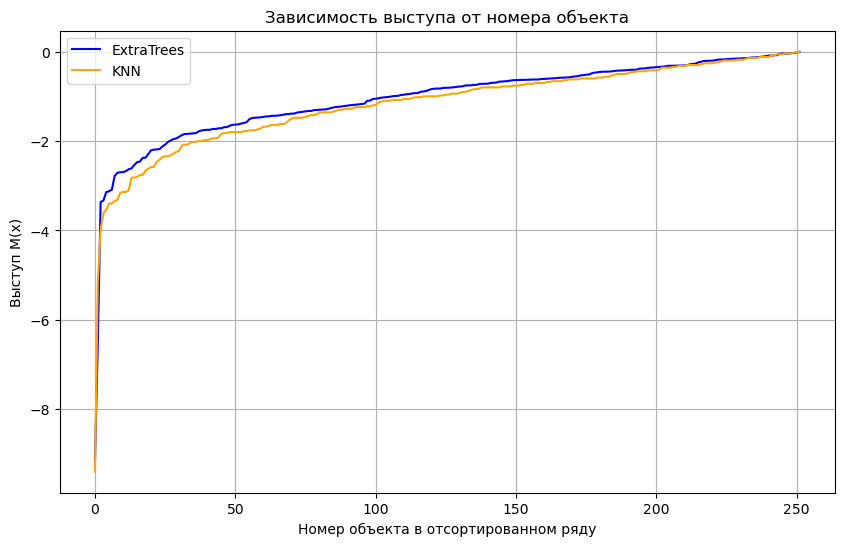

In [357]:
import matplotlib.pyplot as plt

# Сортируем объекты по значению выступа
sorted_et = results.sort_values(by='M_et')
sorted_knn = results.sort_values(by='M_knn')

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_et)), sorted_et['M_et'], label='ExtraTrees', color='blue')
plt.plot(range(len(sorted_knn)), sorted_knn['M_knn'], label='KNN', color='orange')
plt.xlabel('Номер объекта в отсортированном ряду')
plt.ylabel('Выступ M(x)')
plt.title('Зависимость выступа от номера объекта')
plt.legend()
plt.grid(True)
plt.show()

Выведите на экран 4 случайных выброса с разными значениями целевого признака и объясните эти аномалии в данных (20% баллов - за правильное объяснение). Вам помогут: важные признаки, найденные в предыдущей лаб. работе, и коэффициенты корреляции. ВАЖНО: выступ характеризует не "абстрактную" типичность объекта, а качество предсказания целевого признака!

In [360]:
# Выбираем 4 объекта с разными значениями model_year для каждой модели
outliers_et = outliers_et.groupby('Neck').first().reset_index()
outliers_knn = outliers_knn.groupby('Neck').first().reset_index()

if len(outliers_et) > 4:
    outliers_et = outliers_et.sample(4, random_state=42)
if len(outliers_knn) > 4:
    outliers_knn = outliers_knn.sample(4, random_state=42)

# Добавляем исходные признаки для анализа
outliers_data_et = data.loc[outliers_et['index']].copy()
outliers_data_et['M_et'] = outliers_et['M_et'].values
outliers_data_et['predicted_Neck'] = y_pred_et[outliers_et['index'].values]

outliers_data_knn = data.loc[outliers_knn['index']].copy()
outliers_data_knn['M_knn'] = outliers_knn['M_knn'].values
outliers_data_knn['predicted_Neck'] = y_pred_knn[outliers_knn['index'].values]

# Проверяем согласованность
outliers_data_et['M_et_check'] = -np.abs(outliers_data_et['Neck'] - outliers_data_et['predicted_Neck'])
outliers_data_knn['M_knn_check'] = -np.abs(outliers_data_knn['Neck'] - outliers_data_knn['predicted_Neck'])

# Выводим результаты
print("Итоговые выбросы для ExtraTrees (ошибка M_et, предсказание M_et):")
print(outliers_data_et[['BodyFat', 'Age', 'Height', 'Weight', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'Neck', 'M_et', 'predicted_Neck', 'M_et_check']])

print("\nИтоговые выбросы для KNN (ошибка M_knn, предсказание KNN):")
print(outliers_data_knn[['BodyFat', 'Age', 'Height', 'Weight', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'Neck', 'M_knn', 'predicted_Neck', 'M_knn_check']])

Итоговые выбросы для ExtraTrees (ошибка M_et, предсказание M_et):
     BodyFat  Age  Height  Weight  Chest  Abdomen    Hip  Thigh  Knee  Ankle  \
9       11.7   23    73.5  198.25   99.6     88.6  104.1   63.1  41.7   25.0   
48      13.6   45    68.5  135.75   92.3     83.4   90.4   52.0  35.8   20.6   
42      31.6   48    70.0  217.00  113.3    111.2  114.1   67.7  40.9   25.0   
105     18.0   43    68.5  165.50   93.1     87.3   96.6   54.7  39.0   24.8   

     Biceps  Forearm  Wrist  Neck   M_et  predicted_Neck  M_et_check  
9      35.6     30.0   19.2  42.1 -3.145          38.955      -3.145  
48     28.8     25.5   16.3  32.8 -2.783          35.583      -2.783  
42     36.7     29.8   18.4  37.3 -3.125          40.425      -3.125  
105    31.0     29.4   18.8  31.1 -6.529          37.629      -6.529  

Итоговые выбросы для KNN (ошибка M_knn, предсказание KNN):
     BodyFat  Age  Height  Weight  Chest  Abdomen    Hip  Thigh  Knee  Ankle  \
9       11.7   23    73.5  198.25   99

## Сгущения данных

Найдите в ваших данных сгущения. 
* Для этого попробуйте сначала посмотреть на график рассеяния на главных компонентах. Двумерный рисунок является проекцией многомерной выборки и не позволяет качественно обнаружить сгущения. Чтобы как-то увидеть кластеры, отобразите цветом плотность точек (вычисленную для исходного многомерного пространства). Максимумы плотности покажут проекции сгущений в ваших данных. 

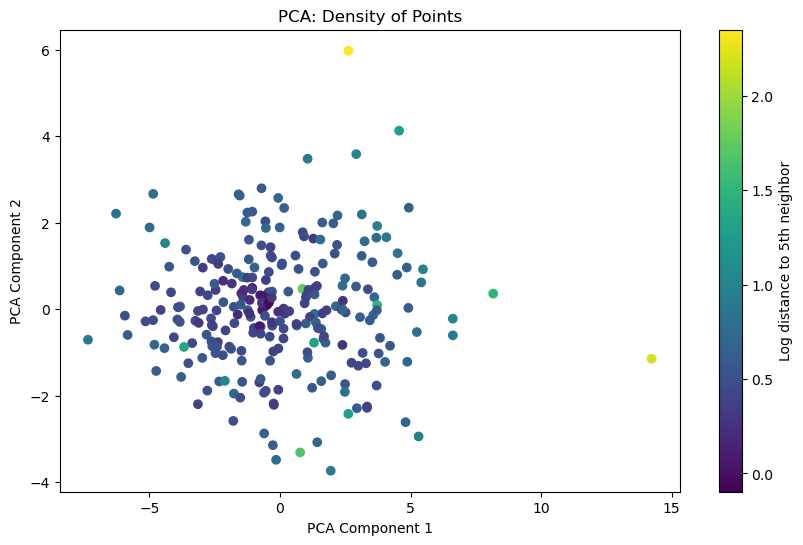

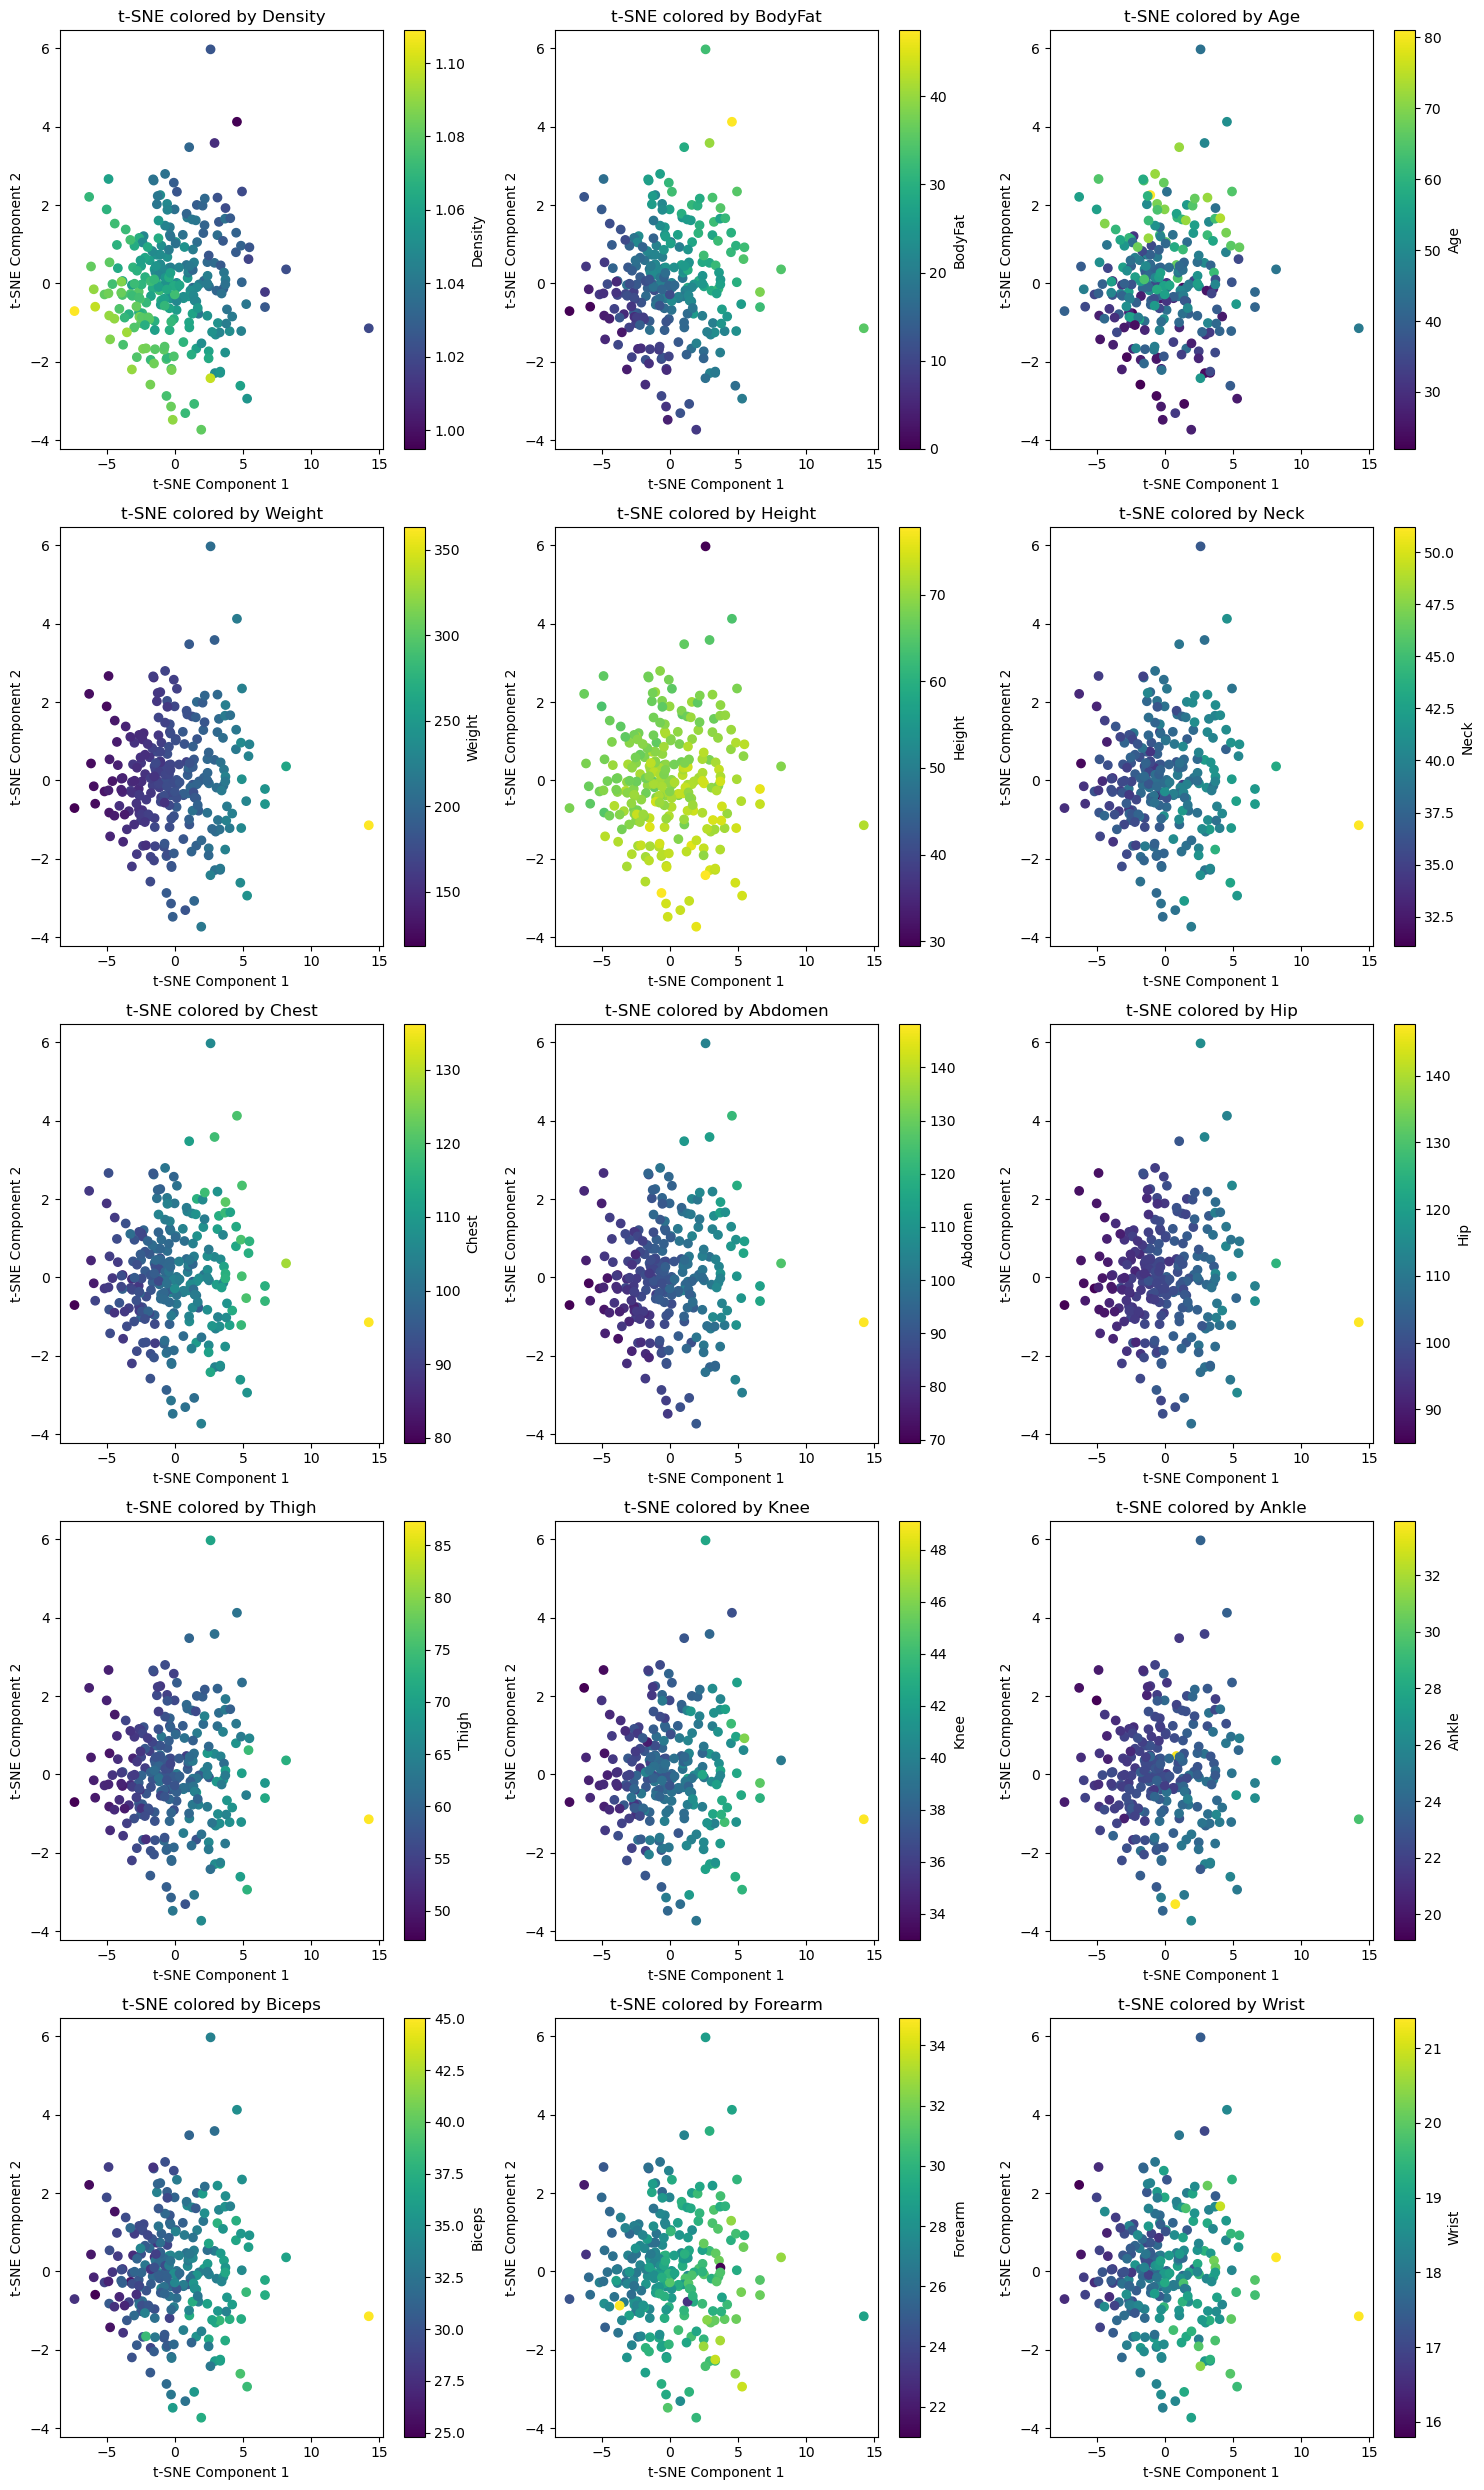

In [388]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
data = pd.read_csv('bodyfat.csv')
data.dropna(inplace=True)

# Создаём бинарный категориальный признак на основе условия
#data['Density_cat'] = data['Density'].apply(lambda x: 'fat' if x > 1.06 else 'thin')
# One-hot encoding для нового категориального признака
#data = pd.get_dummies(data, columns=['Density_cat'], prefix='Density')
#X = data.drop(columns=['Density'])

label = 'Neck'

# Разделяем признаки и целевую переменную
X = data.drop(columns=[label])
y = data[label]

# Нормировка признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)
# Вычисляем плотность через расстояние до min_samples-го соседа
min_samples = 2
d = distance.cdist(X_scaled, X_scaled)
r = np.partition(d, min_samples, axis=1)[:, min_samples]

# График PCA с плотностью
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=np.log(np.abs(r)), cmap='viridis')
plt.colorbar(scatter, label='Log distance to 5th neighbor')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA: Density of Points')
plt.show()

# Графики рассеяния с цветом по всем признакам
features_to_plot = data_with_target.columns  # Все признаки, включая model_year
n_features = len(features_to_plot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data_with_target[feature], cmap='viridis')
    plt.colorbar(scatter, label=feature)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE colored by {feature}')
plt.tight_layout()
plt.show()

* Если вы не увидели сгущения с помощью PCA, примените [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и нарисуйте аналогичный график рассеяния. Поймите и запишите в ответе физический смысл найденных сгущений данных (20% баллов). Это можно сделать, взяв наугад точки внутри кластеров в embadding (т.е. на графике рассеяния) и применив обратное преобразование. Другой хороший прием: строить графики рассеяния, перебирая в качестве цвета различные признаки. Нам нужны те, для которых сгущения красятся в разный цвет.

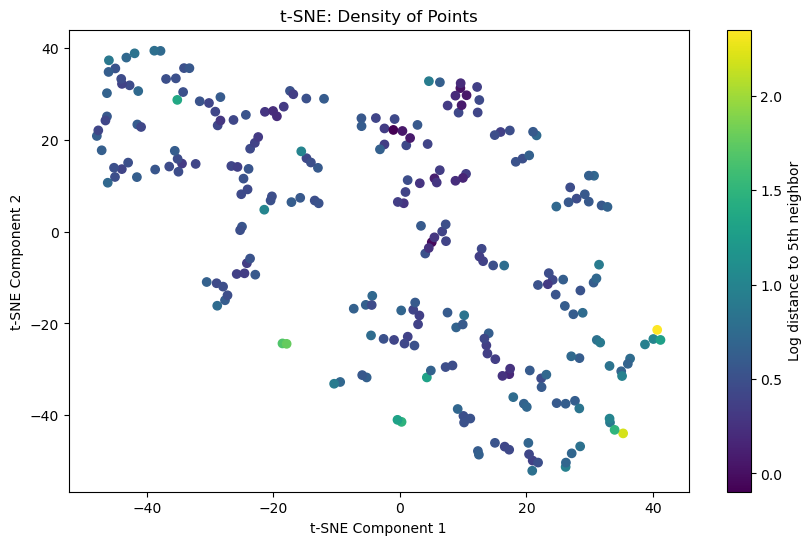

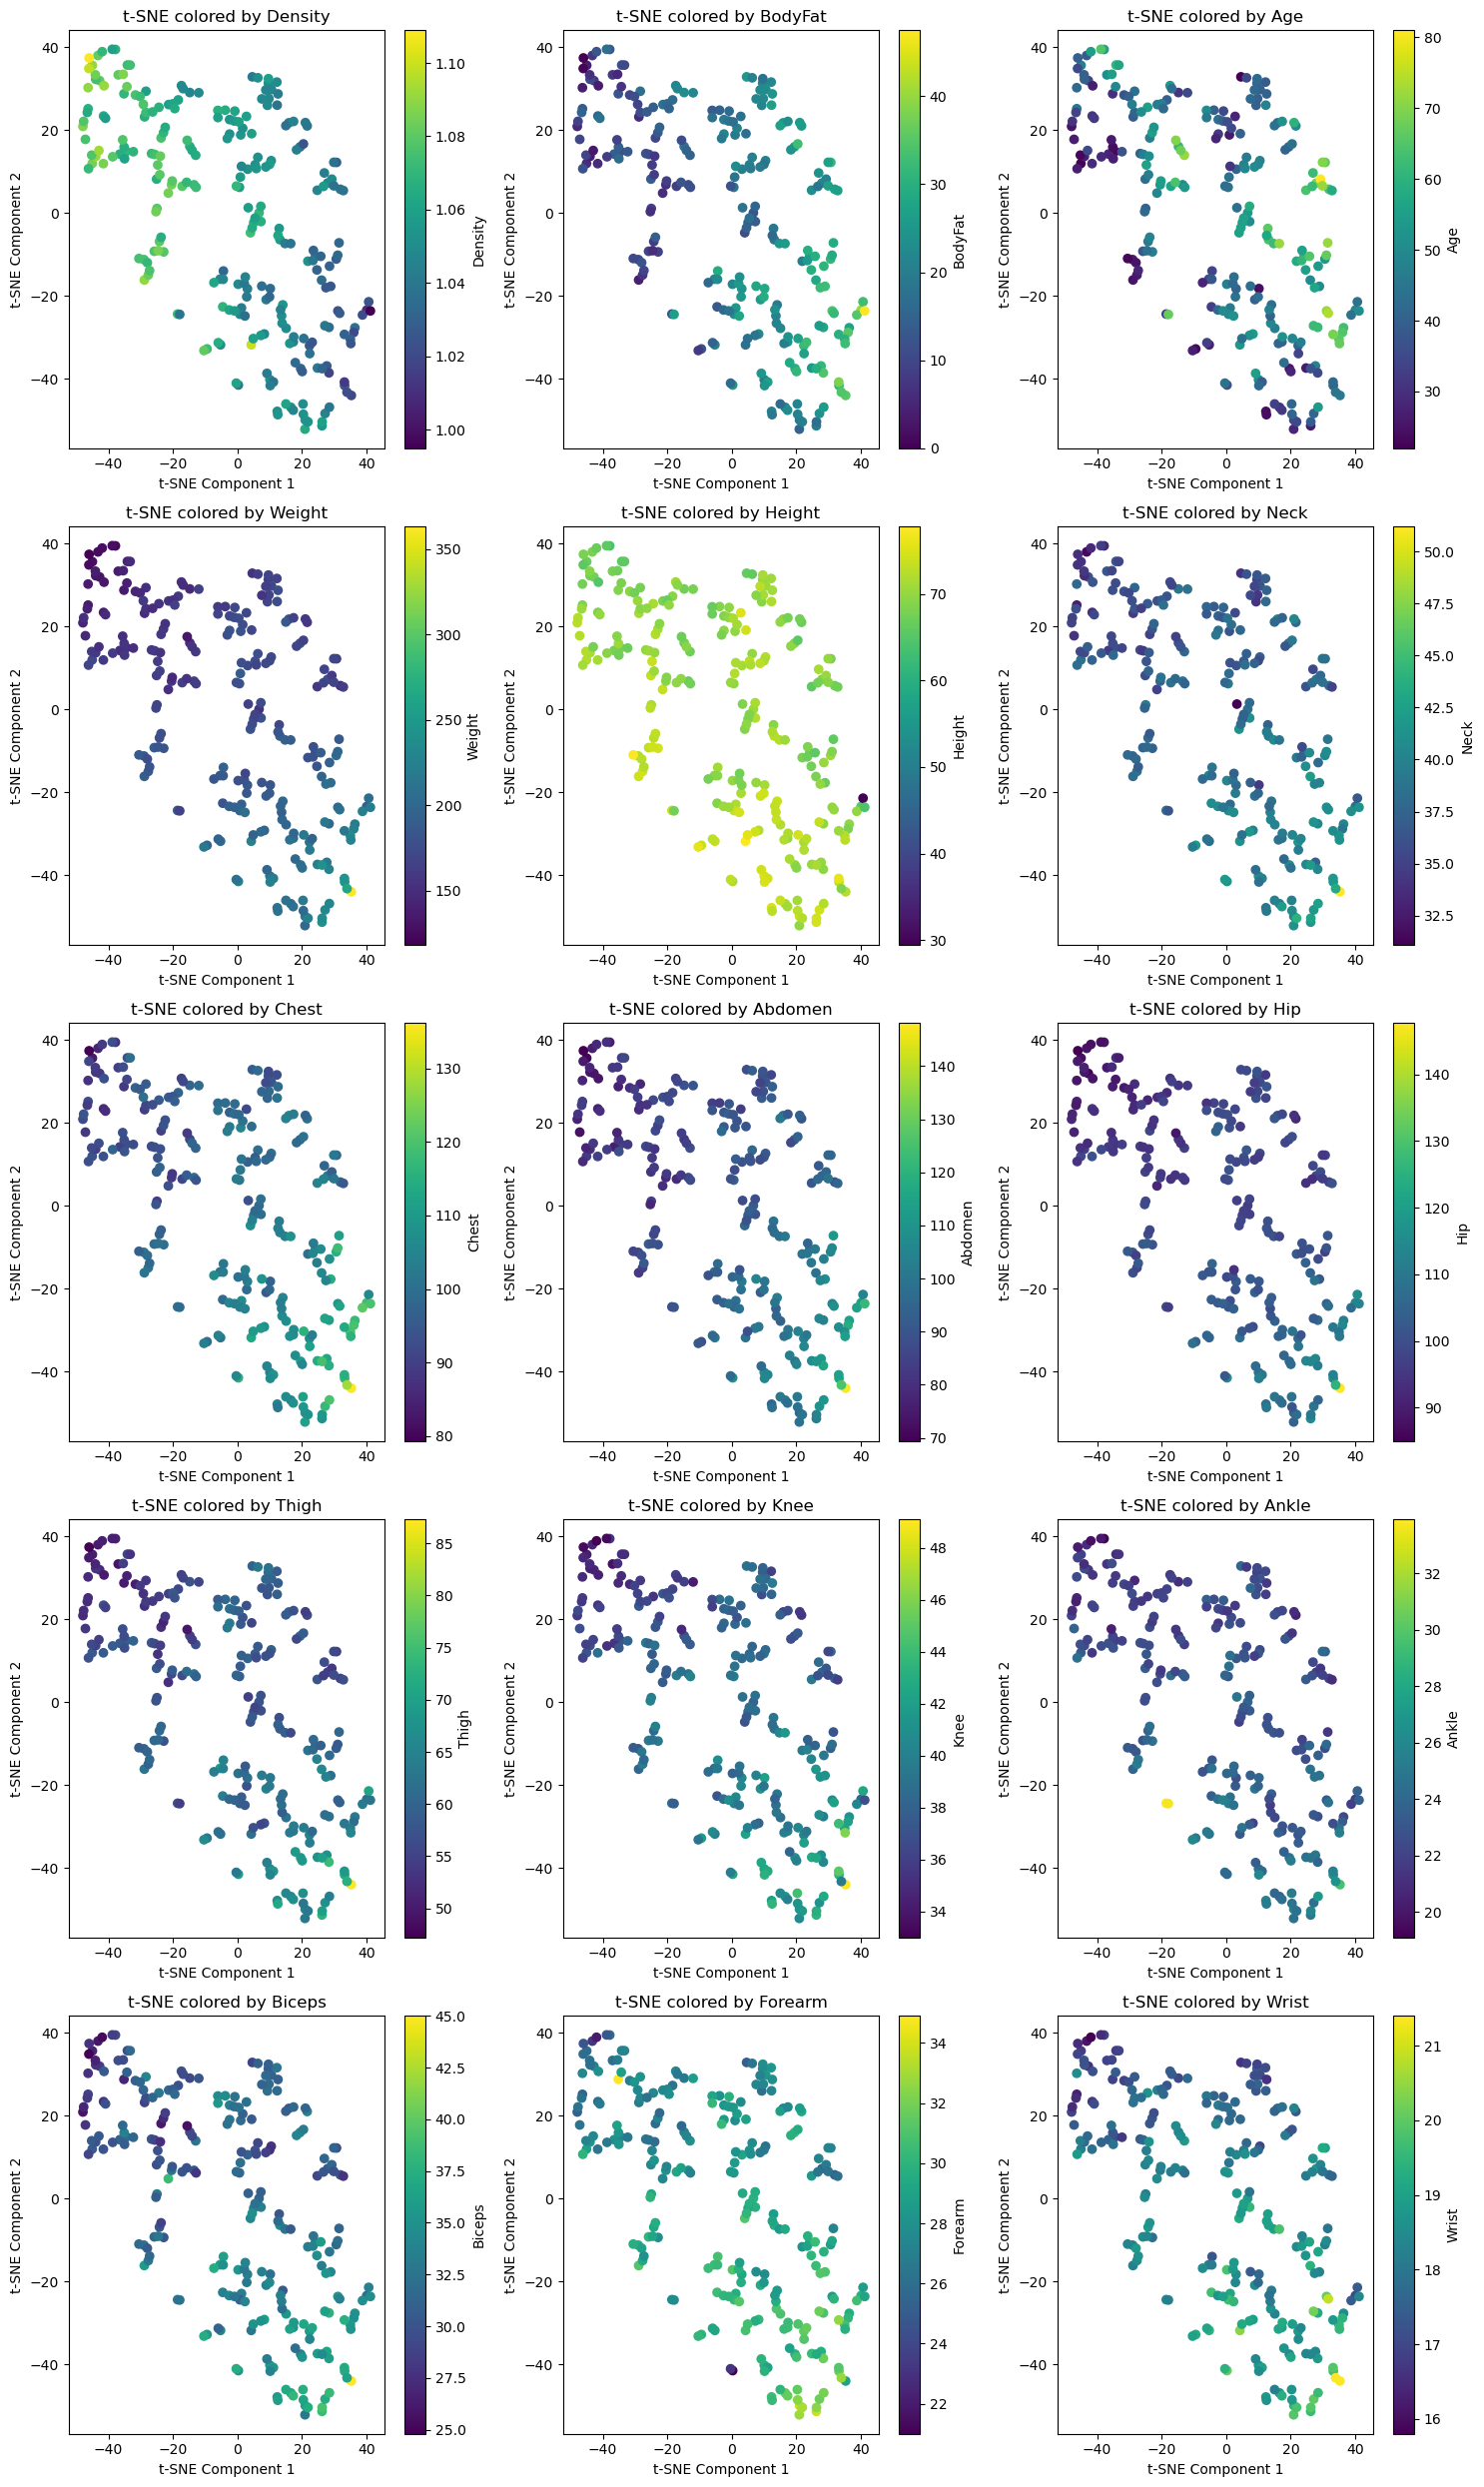

In [445]:
# t-SNE
tsne = TSNE(n_components=2, random_state=43, perplexity=5)
tsne_features = tsne.fit_transform(X_scaled)

# График t-SNE с плотностью
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=np.log(r), cmap='viridis')
plt.colorbar(scatter, label='Log distance to 5th neighbor')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Density of Points')
plt.show()

# Графики рассеяния с цветом по всем признакам
features_to_plot = data_with_target.columns  # Все признаки, включая model_year
n_features = len(features_to_plot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=data_with_target[feature], cmap='viridis')
    plt.colorbar(scatter, label=feature)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE colored by {feature}')
plt.tight_layout()
plt.show()

* Теперь наши сгущения требуется найти точно. Примените [один из методов кластеризации sklearn](https://scikit-learn.org/stable/modules/clustering.html) к нормализованной выборке со всеми признаками без целевого (или к выборке в embadding пространстве). Отобразите на двумерном графике рассеяния на главных компонентах (или в пространстве t-SNE) разным цветом получившиеся кластеры. Нужно так подобрать параметры алгоритма, чтобы он вернул те же кластеры, которые вы наблюдали в предыдущем пункте. При выборе алгоритма будьте внимательны: многие из них основаны на близости точек, а не на связанности кластеров, поэтому при применении к равномерно распределенной на квадрате выборке возвращают фиктивные кластеры. Я вам советую применять DBSCAN. Чтобы подобрать его параметр eps, для некоторого min_samples, постройте график отсортированных расстояний до ближайшего соседа № min_samples и найдите по нему 90% квантиль

Полезный код: вместо расчета плотности точек можно использовать расстояние до n-того соседа. Чтобы посчитать расстояния за разумное время лучше всего использовать пару функций:
```
d = scipy.spatial.distance.cdist(x, x)  # расчет расстояний от каждой точки выборки x до каждой (одна точка - одна строчка матрицы x)
r = np.partition(d, min_samples, axis=1)[:,min_samples]  # поиск min_samples минимальных элементов
```
Если цвета плотности почти всех точек совпадают, попробуйте логарифмировать r: `hue=np.log(r)`

На графике отсортированных расстояний до ближайшего соседа удобно включать логарифмический масштаб по оси y: `plt.yscale('log')`

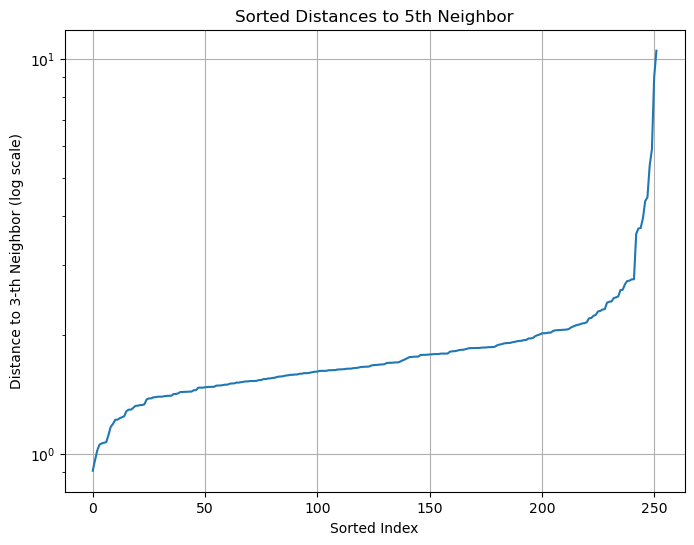

Выбранный eps: 2.0953394527299722


In [448]:
# Подбор eps для DBSCAN
plt.figure(figsize=(8, 6))
plt.plot(np.sort(r))
plt.yscale('log')
plt.xlabel('Sorted Index')
plt.ylabel(f'Distance to {min_samples}-th Neighbor (log scale)')
plt.title('Sorted Distances to 5th Neighbor')
plt.grid(True)
plt.show()

# Настраиваем eps для получения ~5 кластеров
eps = np.percentile(r, 85)  # Уменьшаем до 85% для большего числа кластеров
print(f"Выбранный eps: {eps}")

# DBSCAN на исходных данных
eps = 2  # или другое оптимальное значение (нужно определить)
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm='auto')
clusters = dbscan.fit_predict(X_scaled)

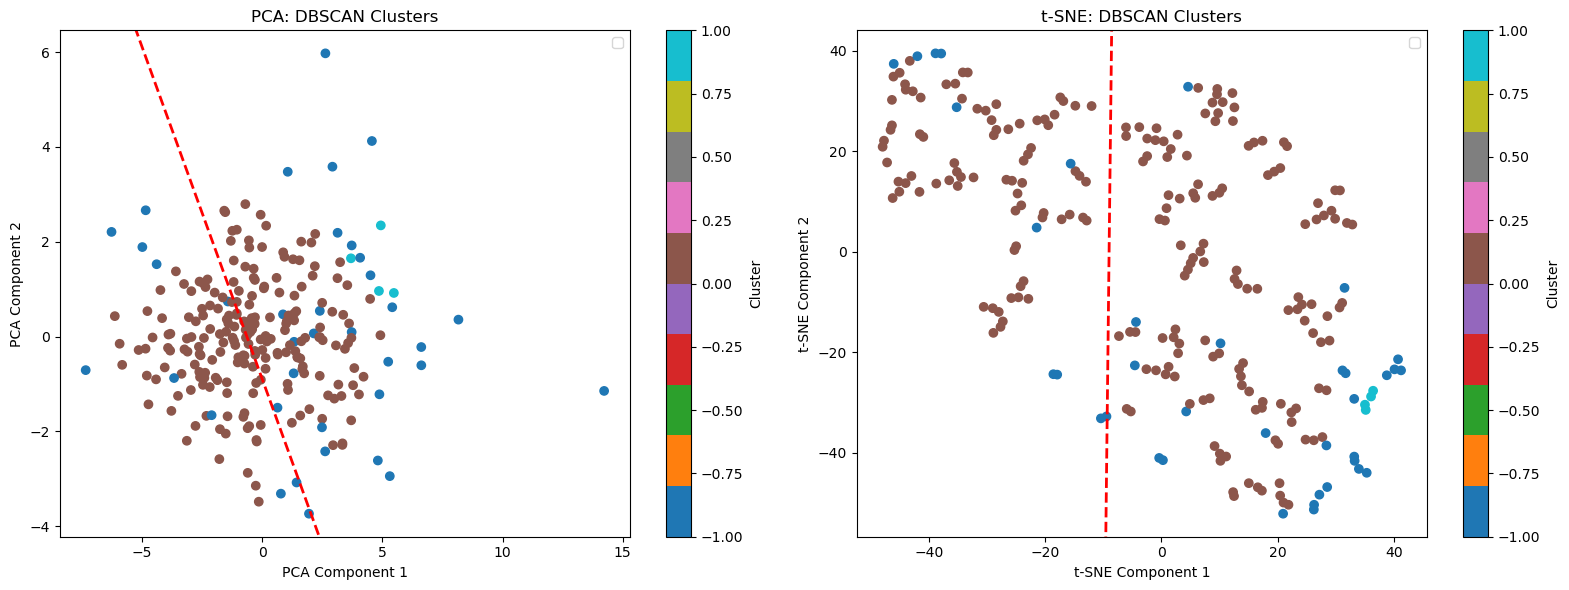

In [454]:
# Создаем фигуру с двумя осями (2 графика слева направо)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Визуализация кластеров на PCA
scatter2 = axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='tab10')
fig.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].set_title('PCA: DBSCAN Clusters')
x_limits = axes[0].get_xlim()
y_limits = axes[0].get_ylim()
xxx = np.linspace(min(pca_features[:, 0]), max(pca_features[:, 0]), 100)
yyy = -1.4*xxx - 0.9
axes[0].plot(xxx, yyy, color='red', linewidth=2, linestyle='--')
axes[0].legend()
# Восстанавливаем границы осей
axes[0].set_xlim(x_limits)
axes[0].set_ylim(y_limits)

# Визуализация кластеров на t-SNE
scatter1 = axes[1].scatter(tsne_features[:, 0], tsne_features[:, 1], c=clusters, cmap='tab10')
fig.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE: DBSCAN Clusters')

x_limits = axes[1].get_xlim()
y_limits = axes[1].get_ylim()
xxx = np.linspace(min(tsne_features[:, 0]), max(tsne_features[:, 1]), 100)
yyy = 100*xxx + 900
axes[1].plot(xxx, yyy, color='red', linewidth=2, linestyle='--')
axes[1].legend()
# Восстанавливаем границы осей
axes[1].set_xlim(x_limits)
axes[1].set_ylim(y_limits)

plt.tight_layout()
plt.show()

In [456]:
# Количество точек в каждом кластере
unique, counts = np.unique(clusters, return_counts=True)
print("Кластеры и их размеры:", dict(zip(unique, counts)))

Кластеры и их размеры: {-1: 37, 0: 211, 1: 4}


In [458]:
# Средние признаки по кластерам (включая model_year)
print("\nСредние признаки по кластерам (включая model_year):")
data_with_target = data.copy()  # Включаем model_year
for cluster in np.unique(clusters):
    if cluster != -1:  # Исключаем шум
        print(f"\nКластер {cluster}:")
        print(data_with_target[clusters == cluster].mean())


Средние признаки по кластерам (включая model_year):

Кластер 0:
Density      1.057577
BodyFat     18.151185
Age         44.436019
Weight     174.338389
Height      70.281991
Neck        37.709479
Chest       99.466351
Abdomen     90.775829
Hip         98.746445
Thigh       58.747393
Knee        38.294787
Ankle       22.895261
Biceps      31.910427
Forearm     28.570142
Wrist       18.125592
dtype: float64

Кластер 1:
Density      1.028475
BodyFat     31.325000
Age         65.250000
Weight     226.412500
Height      70.625000
Neck        40.425000
Chest      118.175000
Abdomen    113.550000
Hip        111.250000
Thigh       63.500000
Knee        42.900000
Ankle       23.925000
Biceps      35.225000
Forearm     30.050000
Wrist       19.225000
dtype: float64


In [460]:
# Выбор случайных точек из каждого кластера
np.random.seed(42)
dense_points = []
for cluster in np.unique(clusters):
    if cluster != -1:  # Исключаем шум
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) > 0:
            # Выбираем до 3 случайных точек из кластера
            selected_indices = np.random.choice(cluster_indices, size=min(3, len(cluster_indices)), replace=False)
            dense_points.extend(selected_indices)

# Показываем признаки выбранных точек
print("\nПризнаки точек в сгущениях:")
dense_data = data_with_target.iloc[dense_points]
dense_data['cluster'] = clusters[dense_points]
print(dense_data)


Признаки точек в сгущениях:
     Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  \
42    1.0279     31.6   48  217.00   70.00  37.3  113.3    111.2  114.1   
198   1.0841      6.6   42  167.25   72.75  37.6   94.0     78.0   99.0   
157   1.0761     10.0   28  182.50   72.25  37.0   98.5     90.8  102.5   
237   1.0372     27.3   63  219.15   69.50  40.2  117.6    113.8  111.8   
243   1.0256     32.6   67  227.75   72.75  41.3  115.8    113.4  109.8   
242   1.0304     30.4   66  234.25   72.00  41.4  119.7    109.0  109.1   

     Thigh  Knee  Ankle  Biceps  Forearm  Wrist  cluster  
42    67.7  40.9   25.0    36.7     29.8   18.4        0  
198   57.5  40.0   22.5    30.6     30.0   18.5        0  
157   60.8  38.5   25.0    31.6     28.0   18.6        0  
237   63.4  41.1   22.3    35.1     29.6   18.5        1  
243   65.6  46.0   25.4    35.3     29.8   19.5        1  
242   63.7  42.4   24.6    35.6     30.7   19.5        1  
